In [1]:
import math
import copy
import numpy as np
from random import random
import matplotlib.pyplot as plt

from math import exp

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
points_x = [x/10 for x in range(-100, 100, 1)]

In [3]:
centers = (
    (0, 0),
    (4, 4),
    (-6, -6),
    (-3, -3),
    (-4, 2),
    (2, -6),
)

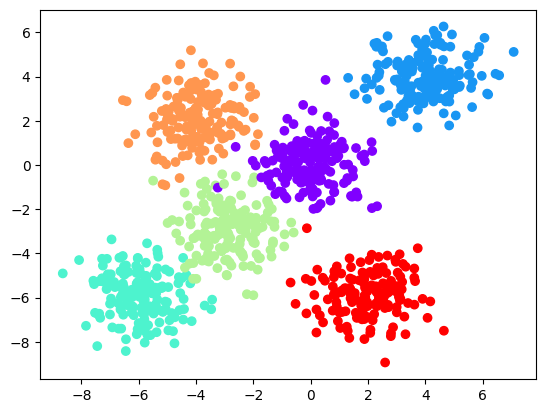

In [4]:
class_count = 6
dataset = datasets.make_blobs(
    n_samples=1000,
    n_features=2,
    random_state=42,
    centers=centers,
)

X = dataset[0]
labels = dataset[1]

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')
plt.show()

In [5]:
class Neuron:
    def __init__(self, prev_layer_size):
        self.weights = [random()*2-1 for i in range(prev_layer_size)]
        self.delta = 0
        self.output = 0

class Perceptron:
    def __init__(self, layers_size):
        self.layers = []
        previous_layer_size = layers_size[0]
        # Создаём слои по архитектуре
        for layer_size in layers_size:
            self.layers.append([Neuron(previous_layer_size + 1) for _ in range(layer_size)])
            previous_layer_size = layer_size

    def forward_propagate(self, input_data, activation_func):
        inputs = input_data

        for num_layer in range(1, len(self.layers)):
            new_inputs = []

            for neuron in self.layers[num_layer]:
                activation = self.impact(neuron.weights, inputs)
                neuron.output = activation_func(activation, False)
                new_inputs.append(neuron.output)

            inputs = new_inputs

        return inputs

    @staticmethod
    def impact(weights, inputs):
        impact = weights[-1]
        for i in range(len(weights) - 1):
            impact += weights[i] * inputs[i]
        return impact

    def backward_propagate_error(self, expected, activation_func):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            errors = []

            if i != len(self.layers) - 1:
                for j in range(len(layer)):
                    error = 0.0
                    for neuron in self.layers[i + 1]:
                        error += (neuron.weights[j] * neuron.delta)
                    errors.append(error)
            else:
                for j in range(len(layer)):
                    neuron = layer[j]
                    errors.append(expected[j] - neuron.output)

            for j in range(len(layer)):
                neuron = layer[j]
                neuron.delta = errors[j] * activation_func(neuron.output, True)

    def update_weights(self, row, l_rate):
        for i in range(len(self.layers)):
            if i == 0:
                inputs = row
            else:
                inputs = [neuron.output for neuron in self.layers[i - 1]]

            for neuron in self.layers[i]:
                for j in range(len(inputs)):
                    neuron.weights[j] += l_rate * neuron.delta * inputs[j]
                neuron.weights[-1] += l_rate * neuron.delta

    def train_network(self, x_train, y_train, x_test, y_test, l_rate, n_epoch, activation_func):
        print(f'Train l_rate: {l_rate}, epochs: {n_epoch}... ', end='')
        history = []
        for epoch in range(n_epoch):
            sum_error_train = 0
            sum_error_test = 0
            for i in range(len(x_train)):
                outputs = self.forward_propagate(x_train[i], activation_func)
                # Квадратичная ошибка
                sum_error_train += math.sqrt(sum([(y_train[i][j] - outputs[j]) ** 2 for j in range(len(y_train[i]))]) / len(outputs))
                self.backward_propagate_error(y_train[i], activation_func)
                self.update_weights(x_train[i], l_rate)

            for i in range(len(x_test)):
                outputs = self.forward_propagate(x_test[i], activation_func)
                sum_error_test += math.sqrt(sum([(y_test[i][j] - outputs[j]) ** 2 for j in range(len(y_test[i]))]) / len(outputs))

            history.append([sum_error_train/len(x_train), sum_error_test/len(x_test)])

        print('done')
        return history

    def predict(self, data, activation_func):
        outputs = self.forward_propagate(data, activation_func)
        return outputs

In [6]:
def sigmoid(x, derivative=False):
    if not derivative:
        a = 1.0 / (1.0 + exp(-x))
        return a
    else:
        a = x * (1.0 - x)
        return a

In [7]:
def plot_lines(lines):
    plt.figure(figsize=(8, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')

    for line in lines:
        plt.plot(line[0], line[1], c='b')

    plt.show()

In [8]:
def label_to_vector(pos, size):
    vec = [0 for _ in range(size)]
    vec[pos - 1] = 1
    return vec

In [9]:
x_data = X.tolist()
y_data = labels.tolist()
y_data = [label_to_vector(y_data[i], class_count) for i in range(len(y_data))]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8)
print(len(x_train), len(x_test), len(y_train), len(y_test))

800 200 800 200


In [10]:
def get_line_points(a: int, b: int, c: int, x):
    return [(-c/a,p) if b==0 else (p,(-c-a*p)/b) for p in x]

In [11]:
def get_lines(perceptron: Perceptron, hidden_layer_size, points):
    perceptron_lines = []
    for i in range(hidden_layer_size):
        perceptron_lines.append(
            get_line_points(
                a=perceptron.layers[1][i].weights[0],
                b=perceptron.layers[1][i].weights[1],
                c=perceptron.layers[1][i].weights[2],
                x=points
            )
        )
    return perceptron_lines

In [12]:
def get_normal(points, min_border = -10, max_border = 10):
    res_x = []
    res_y = []

    for i in range(len(points)):
        if points[i][1] >= min_border and points[i][1] <= max_border:
            res_x.append(points[i][0])
            res_y.append(points[i][1])
    return res_x, res_y

In [13]:
def get_norm_lines(perceptron, hidden_layer_size, points, min_border = -10, max_border = 10):
    lines = get_lines(perceptron, hidden_layer_size, points)
    norm_lines = []
    for line in lines:
        norm_lines.append(get_normal(line, min_border, max_border))
    return norm_lines

In [14]:
def plot_norm_lines(perceptron, hidden_layer_size, points, min_border = -10, max_border = 10):
    norm_lines = get_norm_lines(perceptron, hidden_layer_size, points, min_border, max_border)
    plot_lines(norm_lines)

In [15]:
def get_prediction_grid(perceptron: Perceptron):
    grid_x = []
    grid_y = []
    grid_res = []
    for i in range(-100, 100):
        for j in range(-100, 100):
            grid_x.append(i/10)
            grid_y.append(j/10)

            res = perceptron.forward_propagate([i/10, j/10], sigmoid)
            grid_res.append(res.index(max(res)))

    return grid_x, grid_y, grid_res

In [24]:
layers_size = [2, 4, class_count]
perceptron = Perceptron(layers_size)

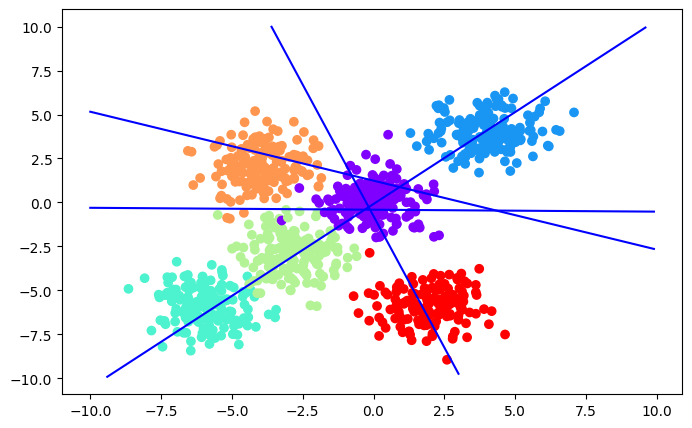

In [25]:
plot_norm_lines(perceptron, layers_size[1], points_x)

Train l_rate: 0.5, epochs: 100... done


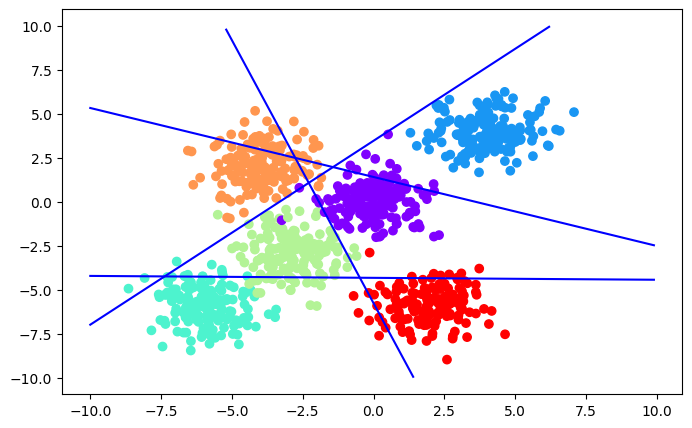

Train l_rate: 0.5, epochs: 300... done


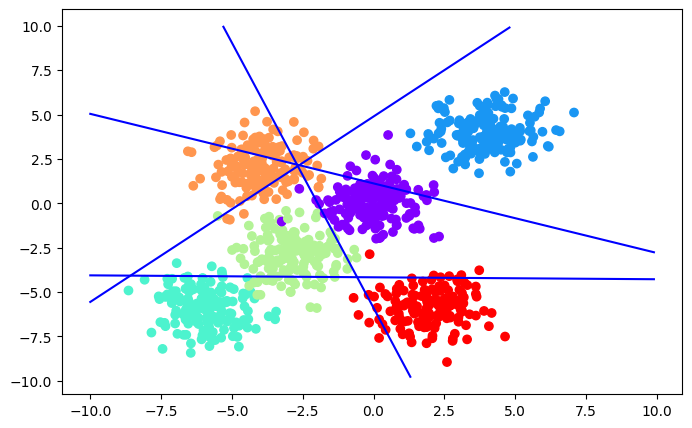

Train l_rate: 0.2, epochs: 300... done
Train l_rate: 0.1, epochs: 300... done
Train l_rate: 0.01, epochs: 300... done
Train l_rate: 0.005, epochs: 300... done
Train l_rate: 0.001, epochs: 300... done
Train l_rate: 0.0001, epochs: 300... done


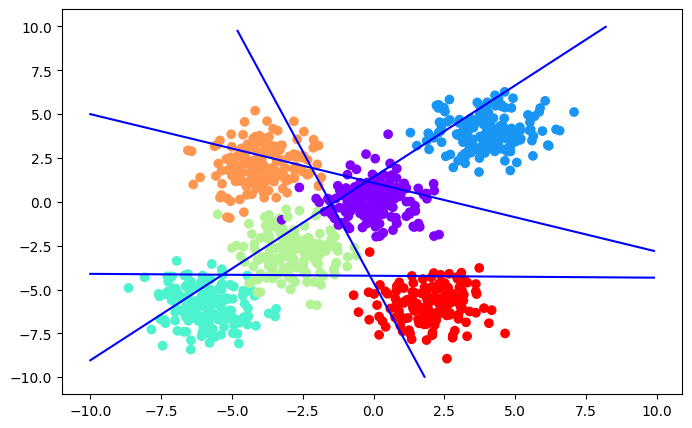

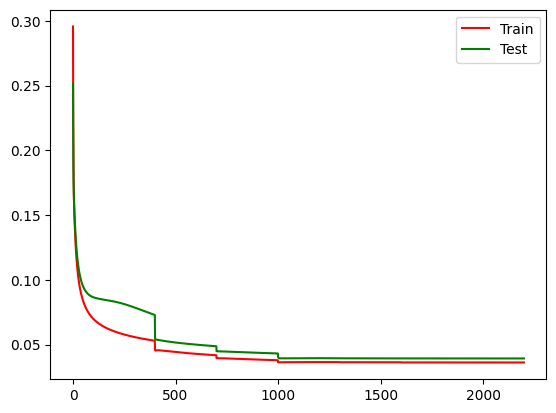

In [26]:
errors = []
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.5, 100, sigmoid)
plot_norm_lines(perceptron, layers_size[1], points_x)
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.5, 300, sigmoid)
plot_norm_lines(perceptron, layers_size[1], points_x)
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.2, 300, sigmoid)
# plot_norm_lines(perceptron, layers_size[1], points_x)
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.1, 300, sigmoid)
# plot_norm_lines(perceptron, layers_size[1], points_x)
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.01, 300, sigmoid)
# plot_norm_lines(perceptron, layers_size[1], points_x)
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.005, 300, sigmoid)
# plot_norm_lines(perceptron, layers_size[1], points_x)
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.001, 300, sigmoid)
# plot_norm_lines(perceptron, layers_size[1], points_x)
errors += perceptron.train_network(x_train, y_train, x_test, y_test, 0.0001, 300, sigmoid)
plot_norm_lines(perceptron, layers_size[1], points_x)

errors_data = np.array(errors)

plt.plot(errors_data[:, 0], c='r', label='Train')
plt.plot(errors_data[:, 1], c='g', label='Test')
plt.legend()
plt.show()

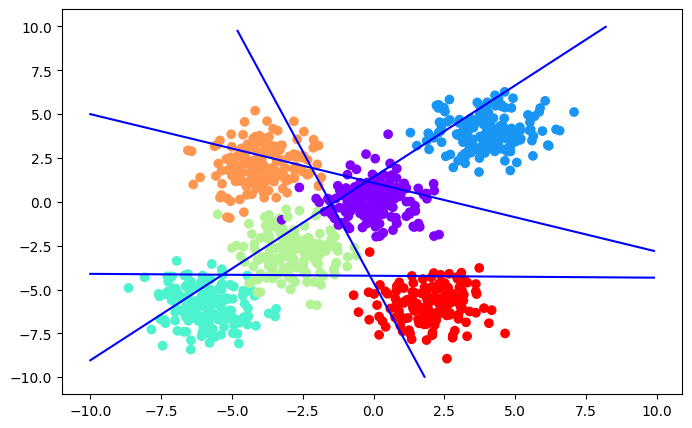

In [27]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')

norm_lines = get_norm_lines(perceptron, layers_size[1], points_x)
for line in norm_lines:
    plt.plot(line[0], line[1], c='b')

plt.show()

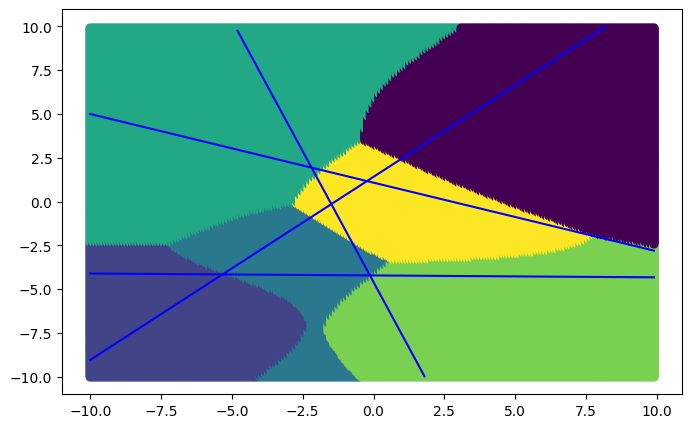

In [28]:
plt.figure(figsize=(8, 5))

norm_lines = get_norm_lines(perceptron, layers_size[1], points_x)
for line in norm_lines:
    plt.plot(line[0], line[1], c='b')

grid_x, grid_y, grid_labels = get_prediction_grid(perceptron)
plt.scatter(grid_x, grid_y, c=grid_labels, )

plt.show()

In [29]:
pred_y = []
true_y = []
for i in range(len(x_test)):
    output = perceptron.forward_propagate(x_test[i], sigmoid)
    pred_y.append(output.index(max(output)))
    true_y.append(y_test[i].index(max(y_test[i])))

In [30]:
print(
    f'Accuracy: {round(accuracy_score(true_y, pred_y), 3)}\n'
    f'Precision: {round(precision_score(true_y, pred_y, average="macro"), 3)}\n'
    f'Recall: {round(recall_score(true_y, pred_y, average="macro"), 3)}\n'
    f'F1-score: {round(f1_score(true_y, pred_y, average="macro"), 3)}\n'
)

Accuracy: 0.985
Precision: 0.984
Recall: 0.985
F1-score: 0.984



------ №0 hidden layer size: 1 ------
Train l_rate: 0.5, epochs: 300... done
Train l_rate: 0.2, epochs: 300... done
Train l_rate: 0.1, epochs: 300... done
Train l_rate: 0.01, epochs: 300... done
Train l_rate: 0.001, epochs: 300... done
------ №1 hidden layer size: 2 ------
Train l_rate: 0.5, epochs: 300... done
Train l_rate: 0.2, epochs: 300... done
Train l_rate: 0.1, epochs: 300... done
Train l_rate: 0.01, epochs: 300... done
Train l_rate: 0.001, epochs: 300... done
------ №2 hidden layer size: 3 ------
Train l_rate: 0.5, epochs: 300... done
Train l_rate: 0.2, epochs: 300... done
Train l_rate: 0.1, epochs: 300... done
Train l_rate: 0.01, epochs: 300... done
Train l_rate: 0.001, epochs: 300... done
------ №3 hidden layer size: 4 ------
Train l_rate: 0.5, epochs: 300... done
Train l_rate: 0.2, epochs: 300... done
Train l_rate: 0.1, epochs: 300... done
Train l_rate: 0.01, epochs: 300... done
Train l_rate: 0.001, epochs: 300... done
------ №4 hidden layer size: 5 ------
Train l_rate: 0.5,

C:\Users\ipuzanov\AppData\Local\Temp\ipykernel_13504\2912377207.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


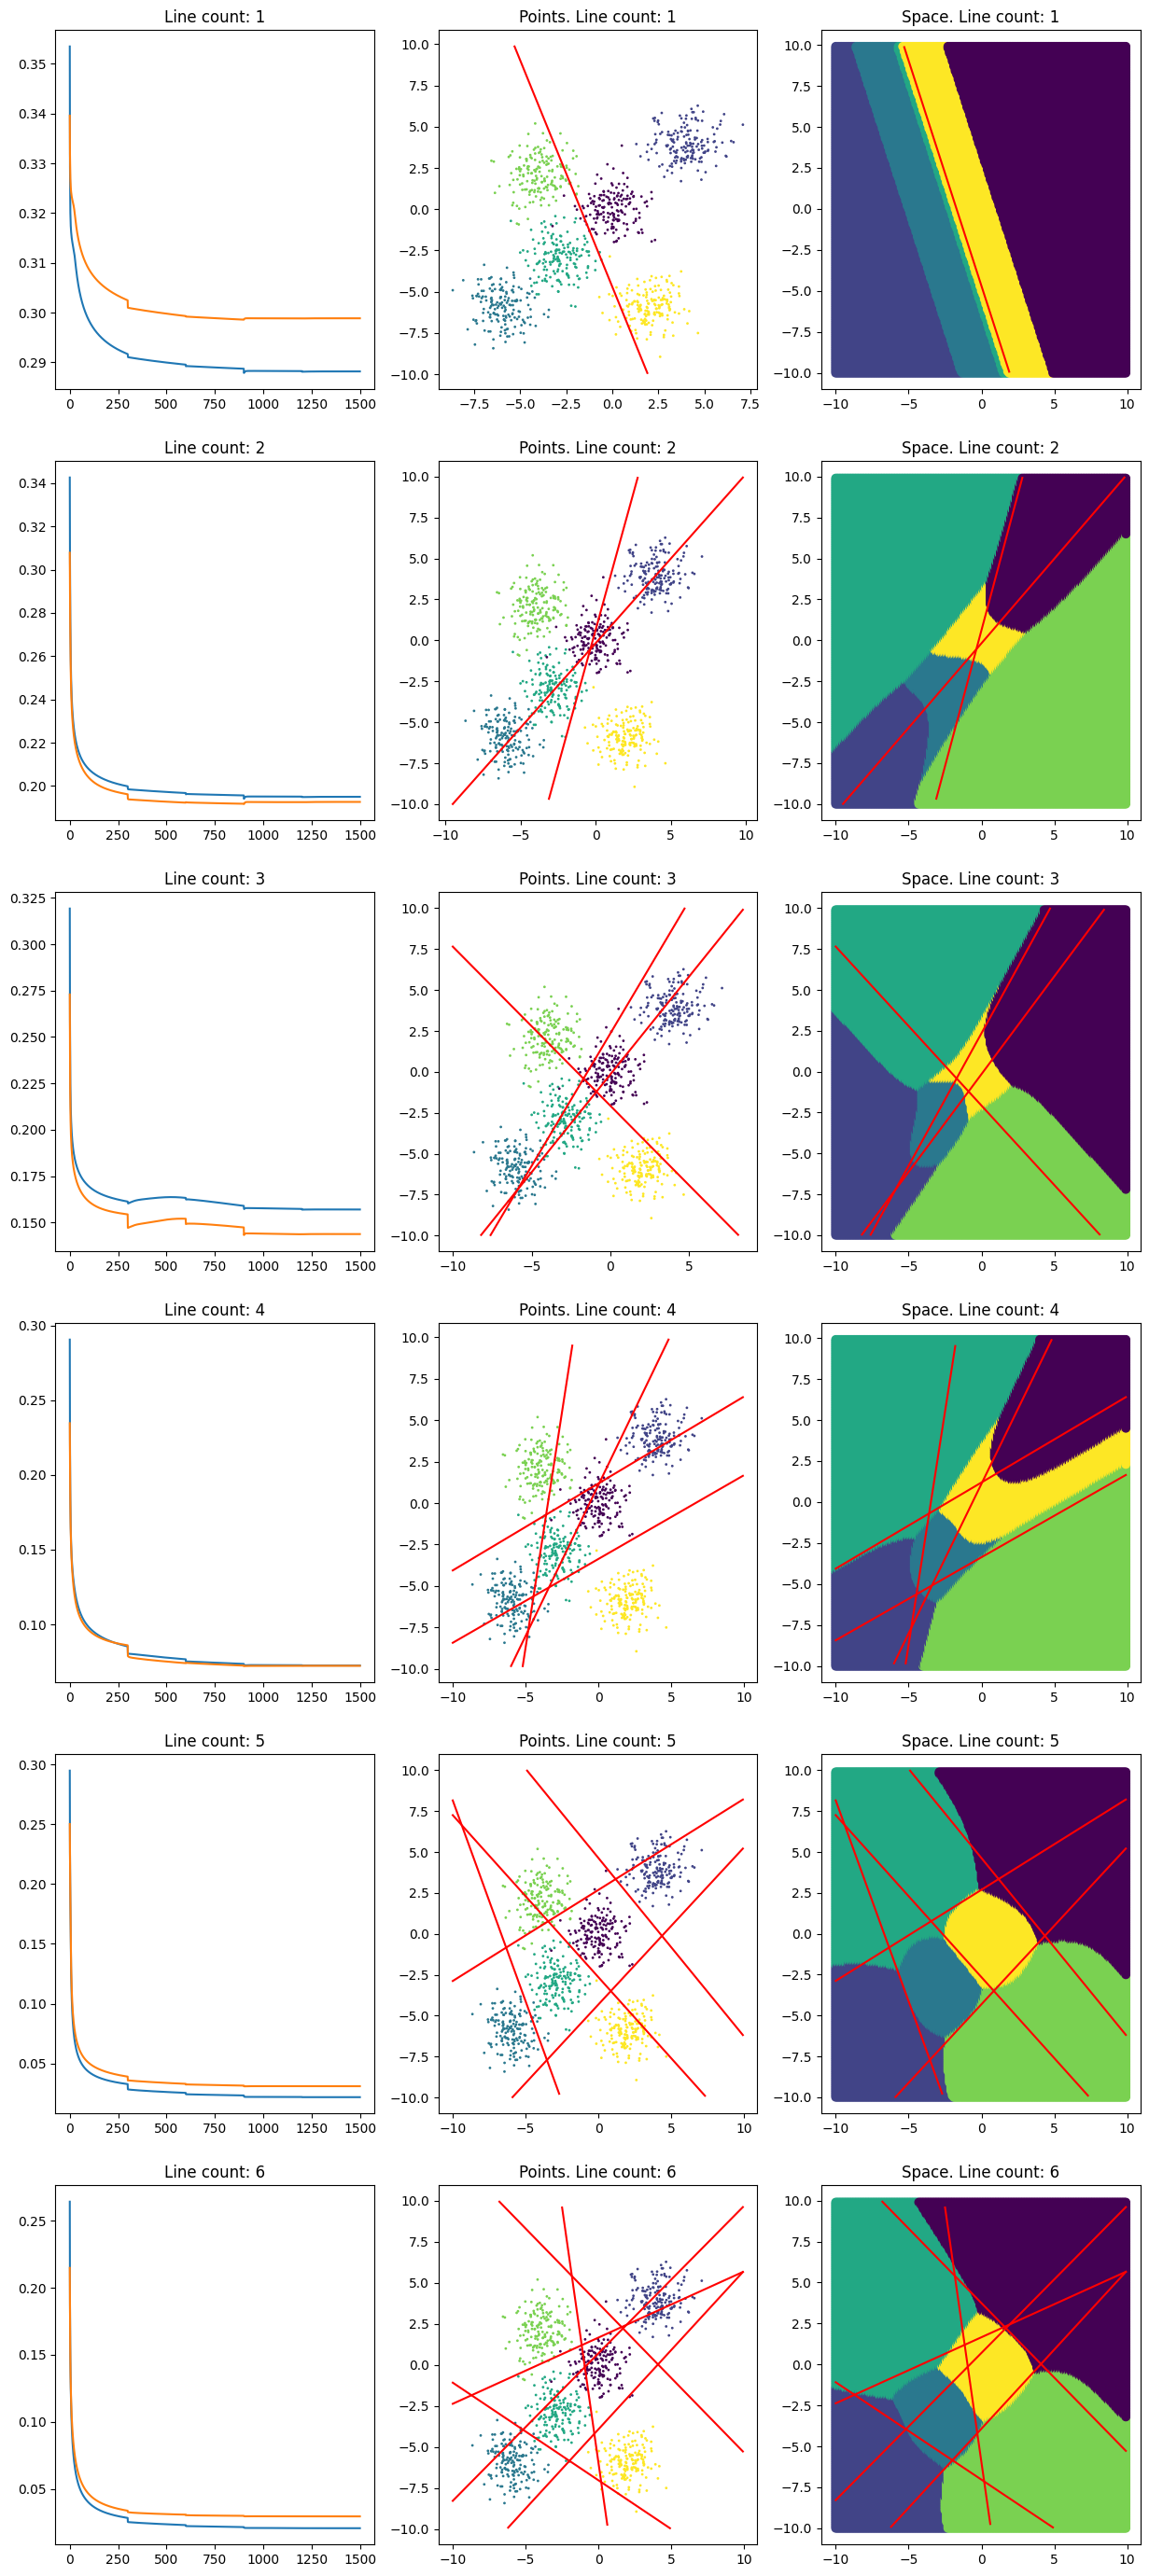

In [141]:
fig, ax = plt.subplots(figsize=(15,35), nrows=class_count, ncols=3)
for i, hidden_layer_size in enumerate(range(1, class_count + 1)):
    print(f'------ №{i} hidden layer size: {hidden_layer_size} ------')
    architecture_ = [2, hidden_layer_size, class_count]
    current_perceptron = Perceptron(architecture_)

    errors = []
    errors += current_perceptron.train_network(x_train, y_train, x_test, y_test, 0.5, 300, sigmoid)
    errors += current_perceptron.train_network(x_train, y_train, x_test, y_test, 0.2, 300, sigmoid)
    errors += current_perceptron.train_network(x_train, y_train, x_test, y_test, 0.1, 300, sigmoid)
    errors += current_perceptron.train_network(x_train, y_train, x_test, y_test, 0.01, 300, sigmoid)
    errors += current_perceptron.train_network(x_train, y_train, x_test, y_test, 0.001, 300, sigmoid)

    ax[i, 0].plot(errors)
    ax[i, 0].set_title(f'Line count: {hidden_layer_size}')

    norm_lines = get_norm_lines(current_perceptron, hidden_layer_size, points_x)
    grid_x, grid_y, grid_labels = get_prediction_grid(current_perceptron)

    ax[i, 1].scatter(X[:, 0], X[:, 1], c=labels, s=1)
    for line in norm_lines:
        ax[i, 1].plot(line[0], line[1], c='r')
    ax[i, 1].set_title(f'Points. Line count: {hidden_layer_size}')

    ax[i, 2].scatter(grid_x, grid_y, c=grid_labels)
    for line in norm_lines:
        ax[i, 2].plot(line[0], line[1], c='r')
    ax[i, 2].set_title(f'Space. Line count: {hidden_layer_size}')

fig.show()


In [23]:
perceptron.layers

[[<__main__.Neuron at 0x17e0559ba30>, <__main__.Neuron at 0x17e0559b8b0>],

In [31]:
from geneticalgorithm2 import geneticalgorithm2 as ga
from geneticalgorithm2 import AlgorithmParams
from geneticalgorithm2 import Mutations, Selection
from geneticalgorithm2 import MiddleCallbacks, ActionConditions

In [32]:
dimension = 28
varbound = np.array([(-20, 20) for i in range(dimension)])

In [33]:
def make_copy_perceptron(input_perceptron):
    hidden_layers_sizes = [len(input_perceptron.layers[i]) for i in range(len(input_perceptron.layers))]

    new_perceptron = Perceptron(hidden_layers_sizes)
    
    for i in range(len(input_perceptron.layers)):
        for j in range(len(input_perceptron.layers[i])):
            for k in range(len(input_perceptron.layers[i][j].weights)):
                new_perceptron.layers[i][j].weights[k] = copy.deepcopy(input_perceptron.layers[i][j].weights[k])
            new_perceptron.layers[i][j].output = copy.deepcopy(input_perceptron.layers[i][j].output)
    
    return new_perceptron

In [34]:
def error_func_minimize(a):
    current_perceptron = make_copy_perceptron(perceptron)

    current_perceptron.layers[1][0].weights = copy.deepcopy(a[0:3])
    current_perceptron.layers[1][1].weights = copy.deepcopy(a[3:6])
    current_perceptron.layers[1][2].weights = copy.deepcopy(a[6:9])
    current_perceptron.layers[1][3].weights = copy.deepcopy(a[9:12])

    current_perceptron.layers[1][0].output = copy.deepcopy(a[12])
    current_perceptron.layers[1][1].output = copy.deepcopy(a[13])
    current_perceptron.layers[1][2].output = copy.deepcopy(a[14])
    current_perceptron.layers[1][3].output = copy.deepcopy(a[15])

    current_perceptron.layers[2][0].weights = copy.deepcopy(a[16:21])
    current_perceptron.layers[2][1].weights = copy.deepcopy(a[21:26])

    current_perceptron.layers[2][0].output = copy.deepcopy(a[26])
    current_perceptron.layers[2][1].output = copy.deepcopy(a[27])

    sum_error_train = 0
    for i in range(len(x_train)):
        outputs = current_perceptron.forward_propagate(x_train[i], sigmoid)
        sum_error_train += math.sqrt(sum([(y_train[i][j] - outputs[j]) ** 2 for j in range(len(y_train[i]))]) / len(outputs))

    return sum_error_train / len(x_train)

In [35]:
def get_output_perceptron(input_perceptron, a):
    current_perceptron = make_copy_perceptron(input_perceptron)
    
    current_perceptron.layers[1][0].weights = copy.deepcopy(a[0:3])
    current_perceptron.layers[1][1].weights = copy.deepcopy(a[3:6])
    current_perceptron.layers[1][2].weights = copy.deepcopy(a[6:9])
    current_perceptron.layers[1][3].weights = copy.deepcopy(a[9:12])
    
    current_perceptron.layers[1][0].output = copy.deepcopy(a[12])
    current_perceptron.layers[1][1].output = copy.deepcopy(a[13])
    current_perceptron.layers[1][2].output = copy.deepcopy(a[14])
    current_perceptron.layers[1][3].output = copy.deepcopy(a[15])
    
    current_perceptron.layers[2][0].weights = copy.deepcopy(a[16:21])
    current_perceptron.layers[2][1].weights = copy.deepcopy(a[21:26])
    
    current_perceptron.layers[2][0].output = copy.deepcopy(a[26])
    current_perceptron.layers[2][1].output = copy.deepcopy(a[27])
    
    return current_perceptron

In [ ]:
def get_output_perceptron(input_perceptron, a):
    current_perceptron = make_copy_perceptron(input_perceptron)

    current_perceptron.layers[1][0].weights = copy.deepcopy(a[0:3])
    current_perceptron.layers[1][1].weights = copy.deepcopy(a[3:6])
    current_perceptron.layers[1][2].weights = copy.deepcopy(a[6:9])
    current_perceptron.layers[1][3].weights = copy.deepcopy(a[9:12])
    current_perceptron.layers[1][3].weights = copy.deepcopy(a[12:15])

    current_perceptron.layers[1][0].output = copy.deepcopy(a[15])
    current_perceptron.layers[1][1].output = copy.deepcopy(a[16])
    current_perceptron.layers[1][2].output = copy.deepcopy(a[17])
    current_perceptron.layers[1][3].output = copy.deepcopy(a[18])
    current_perceptron.layers[1][3].output = copy.deepcopy(a[19])

    current_perceptron.layers[2][0].weights = copy.deepcopy(a[16:21])
    current_perceptron.layers[2][1].weights = copy.deepcopy(a[21:26])

    current_perceptron.layers[2][0].output = copy.deepcopy(a[26])
    current_perceptron.layers[2][1].output = copy.deepcopy(a[27])

    return current_perceptron

In [36]:
def custom_crossover(a: np.ndarray, b: np.ndarray):
    ind1 = copy.deepcopy(a)
    ind2 = copy.deepcopy(b)
    
    eta = 0.5
    
    for i, (x1, x2) in enumerate(zip(ind1, ind2)):
        rand = random()
        if rand <= 0.5:
            beta = 2. * rand
        else:
            beta = 1. / (2. * (1. - rand))
        beta **= 1. / (eta + 1.)
        ind1[i] = 0.5 * (((1 + beta) * x1) + ((1 - beta) * x2))
        ind2[i] = 0.5 * (((1 - beta) * x1) + ((1 + beta) * x2))
        
        
        if ind1[i] > varbound[i, 1]:
            ind1[i] = varbound[i, 1]
        if ind2[i] > varbound[i, 1]:
            ind2[i] = varbound[i, 1]
        if ind1[i] < varbound[i, 0]:
            ind1[i] = varbound[i, 0]
        if ind2[i] < varbound[i, 0]:
            ind2[i] = varbound[i, 0]
    
    return ind1, ind2

In [43]:
model_smart = ga(
    error_func_minimize,
    dimension = dimension,
    variable_type='real', 
    variable_boundaries = varbound,
    algorithm_parameters=AlgorithmParams(
        max_num_iteration = 500,
        population_size = 100,
        mutation_probability = 0.5,
        elit_ratio = 0.1,
        parents_portion = 0.3,
        crossover_type = custom_crossover,
        mutation_type = Mutations.gauss_by_center(sd = 0.2),
        selection_type = Selection.stochastic(),
    )
)

In [44]:
def print_hidden_layers_callback(data):
    fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
    gen = data.last_generation
    best_index = np.argmin([error_func_minimize(gen.variables[i]) for i in range(len(gen.variables))])
    current_perceptron = get_output_perceptron(copy.deepcopy(perceptron), gen.variables[best_index])

    norm_lines = get_norm_lines(current_perceptron, len(current_perceptron.layers[1]), points_x)
    grid_x, grid_y, grid_labels = get_prediction_grid(current_perceptron)

    ax[0].scatter(X[:, 0], X[:, 1], c=labels)
    for line in norm_lines:
        ax[0].plot(line[0], line[1], c='r')

    ax[1].scatter(grid_x, grid_y, c=grid_labels)
    for line in norm_lines:
        ax[1].plot(line[0], line[1], c='r')

    fig.show()
    return data


Set: Average time of function evaluating (secs): 0.021735191345214844 (total = 2.1735191345214844)

Best score before optimization: 0.32422533266966885
||__________________ 10.2% GA is running...51 gen from 500...best value = 0.18467592107929967

C:\Users\ipuzanov\AppData\Local\Temp\ipykernel_8144\937349911.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


                                                                                                                                                                                                        
 The best found solution:
 [ 10.94857988  -3.84349452  18.96734317  -2.60398169  11.68518424
 -14.37484508  18.8749815   -4.59101929 -17.61362656   0.94659791
  -2.31775088  -1.89492536   8.20772567  -0.22223033   5.61826759
  15.03400509   8.88239084   5.33256533   2.82164813 -17.59215567
 -12.60015094 -19.99424691 -15.67287062 -10.48992756   5.60440794
  -1.9102365   14.63837964  -6.22634014]

 Objective function:
 0.12650746310338784

 Used generations: 500
 Used time: 690 seconds


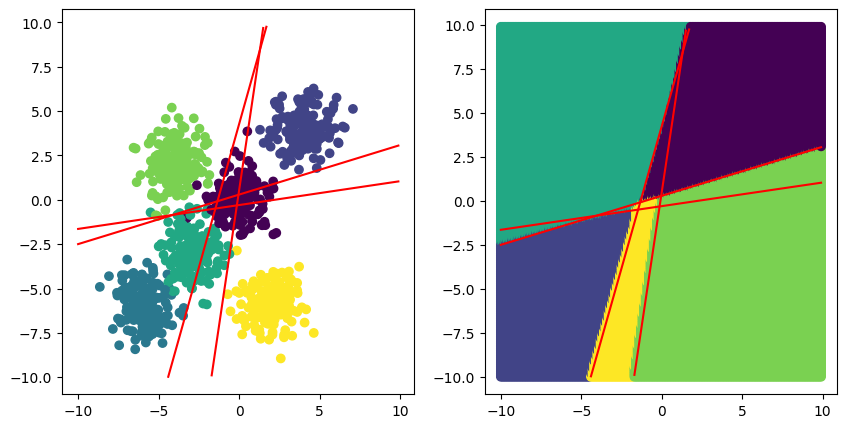

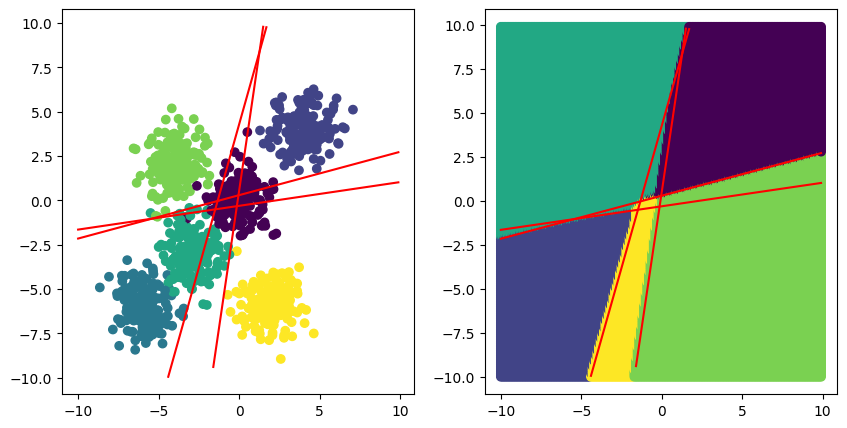

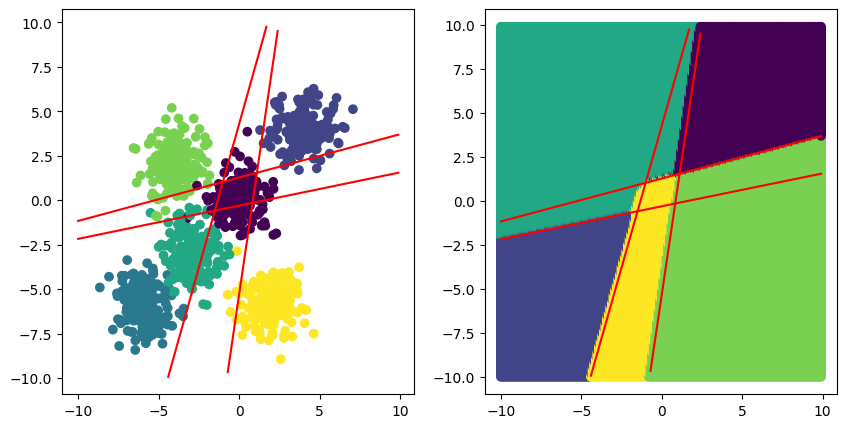

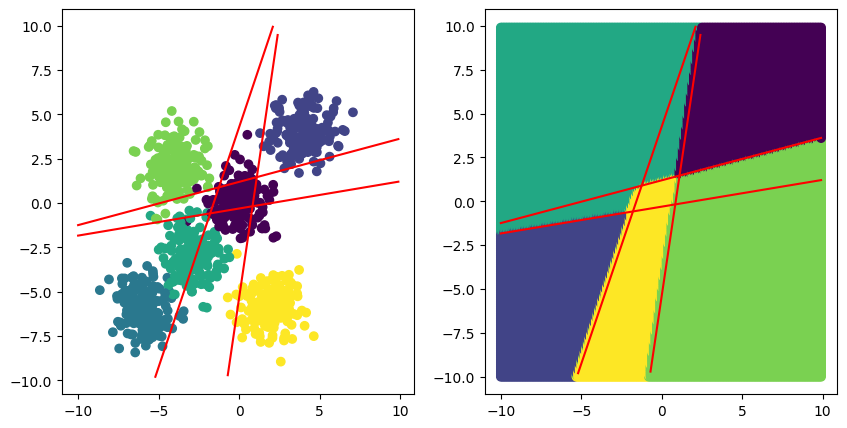

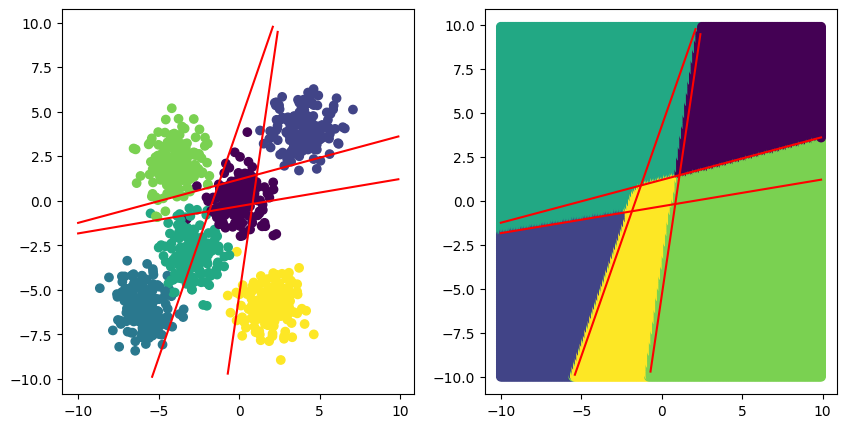

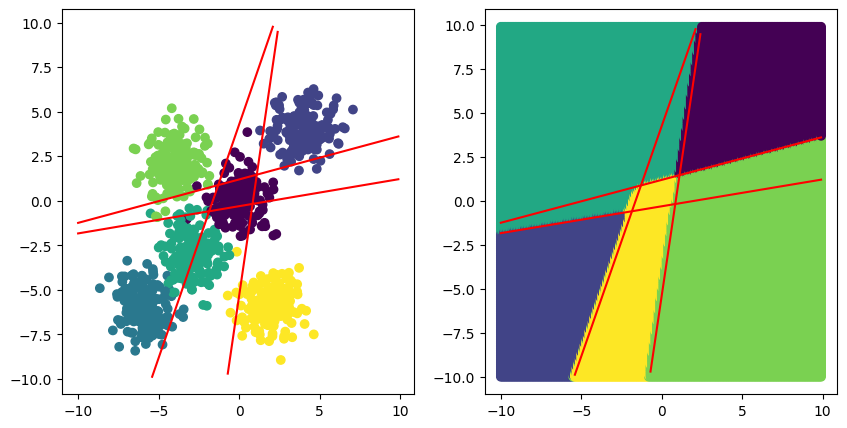

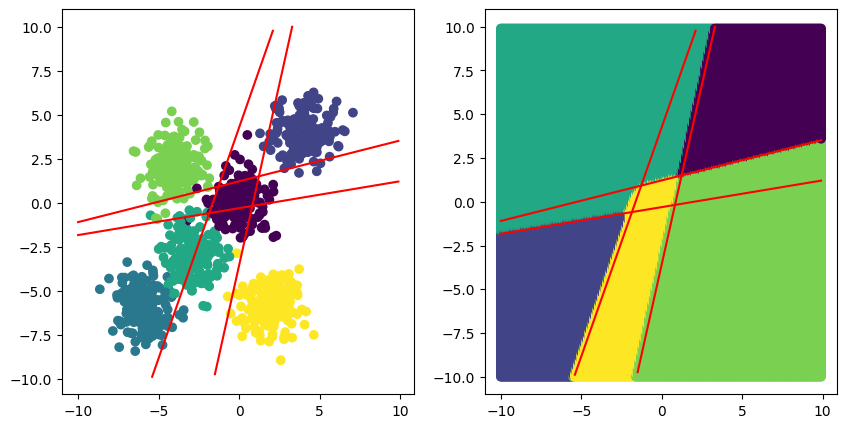

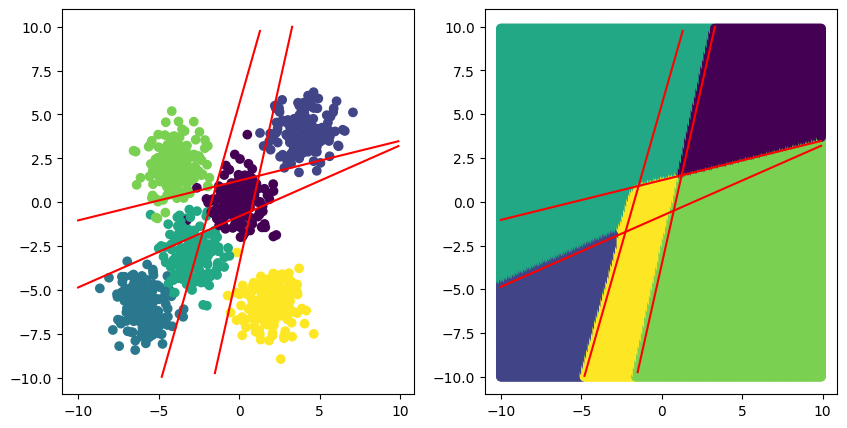

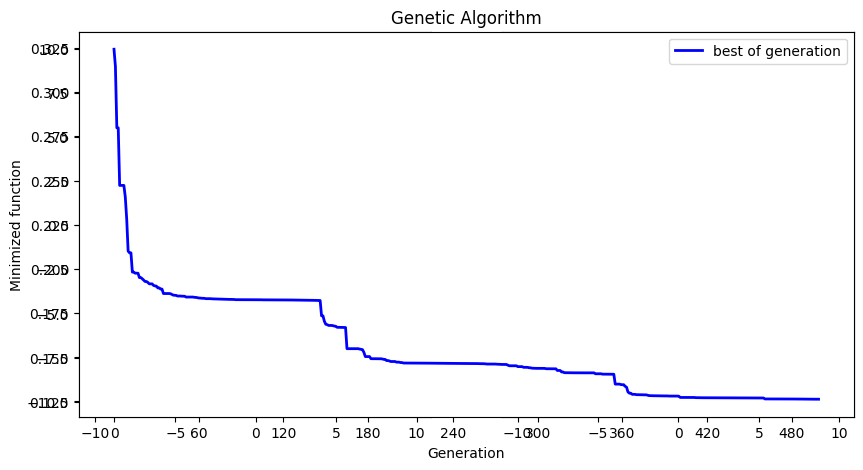

In [45]:
result = model_smart.run(
    middle_callbacks = [
        MiddleCallbacks.UniversalCallback(
            print_hidden_layers_callback,
            ActionConditions.EachGen(generation_step = 50)
        )
    ]
)

C:\Users\ipuzanov\AppData\Local\Temp\ipykernel_8144\680743644.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


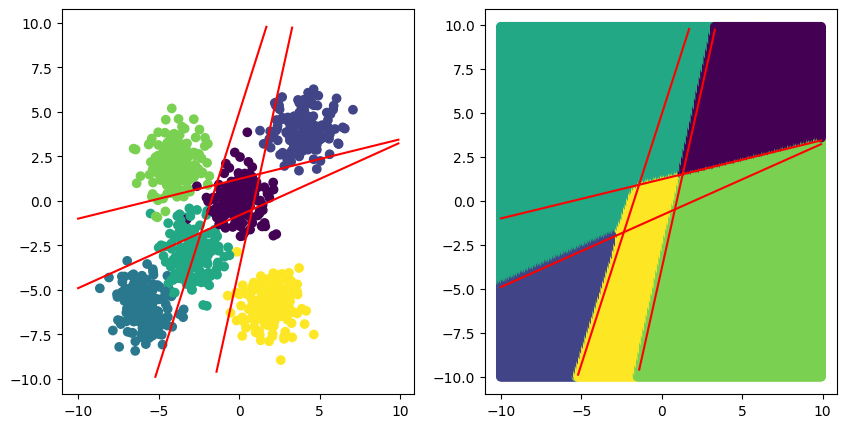

In [46]:
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

new_perceptron = get_output_perceptron(copy.deepcopy(perceptron), result.variable)

norm_lines = get_norm_lines(new_perceptron, len(new_perceptron.layers[1]), points_x)
grid_x, grid_y, grid_labels = get_prediction_grid(new_perceptron)

ax[0].scatter(X[:, 0], X[:, 1], c=labels)
for line in norm_lines:
    ax[0].plot(line[0], line[1], c='r')

ax[1].scatter(grid_x, grid_y, c=grid_labels)
for line in norm_lines:
    ax[1].plot(line[0], line[1], c='r')

fig.show()

In [47]:
model_smart.result.variable

array([ 10.94857988,  -3.84349452,  18.96734317,  -2.60398169,
        11.68518424, -14.37484508,  18.8749815 ,  -4.59101929,
       -17.61362656,   0.94659791,  -2.31775088,  -1.89492536,
         8.20772567,  -0.22223033,   5.61826759,  15.03400509,
         8.88239084,   5.33256533,   2.82164813, -17.59215567,
       -12.60015094, -19.99424691, -15.67287062, -10.48992756,
         5.60440794,  -1.9102365 ,  14.63837964,  -6.22634014])

In [48]:
pred_y = []
true_y = []
for i in range(len(x_test)):
    output = new_perceptron.forward_propagate(x_test[i], sigmoid)
    pred_y.append(output.index(max(output)))
    true_y.append(y_test[i].index(max(y_test[i])))

In [49]:
print(
    f'Accuracy: {round(accuracy_score(true_y, pred_y), 3)}\n'
    f'Precision: {round(precision_score(true_y, pred_y, average="macro"), 3)}\n'
    f'Recall: {round(recall_score(true_y, pred_y, average="macro"), 3)}\n'
    f'F1-score: {round(f1_score(true_y, pred_y, average="macro"), 3)}\n'
)

Accuracy: 0.765
Precision: 0.656
Recall: 0.767
F1-score: 0.703



C:\Users\ipuzanov\PycharmProjects\BMSTU\venv10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
